# DL - Project - Physics-Informed Neural Networks

## Introduction
This notebook implements a Physics-Informed Neural Network (PINN) to solve the Burgers' equation. It is based on the following reference:

- Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "[Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)." Journal of Computational Physics 378 (2019): 686-707.

- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "[Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561)." arXiv preprint arXiv:1711.10561 (2017).

- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "[Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10566)." arXiv preprint arXiv:1711.10566 (2017).

You can find find the original implementation [here](https://maziarraissi.github.io/PINNs/)


NOTE: The official implementation is using TensorFlow while this one is using PyTorch.

In this notebook, we will:
- implement the PINN architecture using PyTorch
- train the PINN to solve the Burgers' equation
- visualize some results and problem setup
- analyse the impact of some hyperparameters as in the reference paper
- explore some extensions such as other hyperparameters, hybrid-PINNs comparison to standard NN

In [1]:
# Import the necessary libraries and modules

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import yaml
import json


from src.viz import visualize_collocation_points
from src.networks import PINNforward, PINNinverse
from src.burger_eq import generate_data
from src.utils import approximation_error

In [2]:
# Set random seeds for reproductibility

np.random.seed(1234);
torch.manual_seed(1234);

In [3]:
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')  # Force CPU usage
print(f"Using device: {device}")

Using device: cpu


## Data-Driven Solution of forward Problem of Burgers' Equation

In [4]:
# Load default parameters / hyperparameters from default config file
default_config = yaml.safe_load(open("config.yaml", "r"))
print(default_config)

{'activation': 'nn.Tanh', 'device': 'cpu', 'epochs': 1, 'lambda_bc': 1, 'lambda_ic': 1, 'layers': [2, 20, 20, 20, 20, 20, 20, 20, 20, 1], 'n_collocation': 2000, 'n_u': 60, 'nu': 0.003183098861837907, 'optimizer': {'history_size': 50, 'line_search_fn': 'strong_wolfe', 'lr': 1.0, 'max_eval': 50000, 'max_iter': 50000, 'tolerance_change': 1e-09, 'tolerance_grad': 1e-07, 'type': 'LBFGS'}}


In [7]:
print(default_config["activation"])
# Get the activation class from the string
activation_name = default_config["activation"]
if activation_name.startswith("nn."):
    activation_class = getattr(nn, activation_name.split(".")[-1])
    test = activation_class()
else:
    raise ValueError(f"Unknown activation function: {activation_name}")

print(f"Loaded activation: {test}")

nn.Tanh
Loaded activation: Tanh()


In [4]:
# Hyperparameters

nu = 0.01 / np.pi  # Viscosity coefficient
n_u = 50          # Total number of initial and boundary points
n_collocation = 5000 # Number of interior collocation points
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1] # Network architecture

# With L-BFGS, each epoch can do up to max_iter internal iterations
# So we use fewer epochs but each epoch is much more powerful
epochs = 1  # Following the paper's maxiter parameter
lambda_pde = 1  # Weight for initial condition loss
lambda_icbc = 1  # Weight for boundary condition loss
activation = nn.Tanh()

In [ ]:
# Instanciate PINN model

pinn_model = PINNforward(layers=layers, activation=activation)

# Using L-BFGS-B optimizer with parameters from the original paper
# Paper parameters:
# method = 'L-BFGS-B', options = {'maxiter': 50000, 'maxfun': 50000, 
#                                   'maxcor': 50, 'maxls': 50, 
#                                   'ftol': 1.0 * np.finfo(float).eps}
pinn_optimizer = optim.LBFGS(
    pinn_model.parameters(), 
    lr=1.0,  # Learning rate (typically 1.0 for L-BFGS)
    max_iter=50000,  # maxiter: Maximum number of iterations per optimization step
    max_eval=50000,  # maxfun: Maximum number of function evaluations per optimization step
    tolerance_grad=1e-7,  # Termination tolerance on first order optimality
    tolerance_change=1.0 * np.finfo(float).eps,  # ftol: Termination tolerance on function value/parameter changes
    history_size=100,  # maxcor: Update history size (number of correction pairs to remember)
    line_search_fn='strong_wolfe'  # Line search algorithm (maxls is used internally)
)

In [ ]:
# Generate training data

print("\nGenerating training data...")
data = generate_data(n_u, n_collocation, device=device)

In [ ]:
# Let's visualize the collocation points that are used to enforce the law of physics (from Partial Differential Equation)

visualize_collocation_points(data)

In [ ]:
# Train model
print("\nTraining PINN...")
pinn_model.to(device)
loss_history_pinn, current_loss_pinn = pinn_model.train_pinn(pinn_optimizer, data, nu, epochs, lambda_pde, lambda_icbc, log_interval=None)
print("Training completed.")

# Save the trained model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pinn_model.save_model(f"pinn_burgers_model_{timestamp}.pth")


In [ ]:
# Evaluate the solution
from utils import evaluate_solution

# Evaluate solution - pass device to ensure proper tensor handling
print("\nEvaluating PINN solution on grid...")
X_pinn, T_pinn, U_pinn = evaluate_solution(pinn_model, n_x=200, n_t=200, device=device)


In [ ]:
# Approximation errors

pinn_error = approximation_error(pinn_model)


print("\nApproximation Errors:")
print(f"\nPINN L2 Error: {np.mean(pinn_error[0]):.6e}")


In [ ]:
# Visualize results
from src.viz import visualize_results
print("\nGenerating visualizations...")
visualize_results(
	X_pinn, T_pinn, U_pinn, current_loss_pinn, path="burgers_results_pinn.png"
)


### Analysis of impact of collocation points and IC/BC points

In [ ]:
N_f = [2000, 4000, 6000, 7000, 8000, 10000]
N_u = [20, 40, 60, 80, 100, 200]

errors_pinn = np.zeros((len(N_f), len(N_u)))
for n_collocation in N_f:
    for n_u in N_u:
        np.random.seed(1234)
        torch.manual_seed(1234)

        print(f"\nTraining PINN with N_f={n_collocation}, N_u={n_u}...")
        # Generate training data
        print("\nGenerating training data...")
        data = generate_data(n_u, n_collocation)
        print(f"Data generated with {n_u} IC/BC points and {n_collocation} collocation points.")
        # Instanciate and train PINN model
        pinn_model = PINNforward(layers=layers, activation=activation)
        pinn_optimizer = optim.LBFGS(
            pinn_model.parameters(), 
            lr=1.0,  
            max_iter=50000,  
            max_eval=50000,  
            tolerance_grad=1e-7,  
            tolerance_change=1.0 * np.finfo(float).eps,  
            history_size=50,  
            line_search_fn='strong_wolfe'  
        )
        print("\nTraining PINN...")
        pinn_model.train_pinn(pinn_optimizer, data, nu, epochs, lambda_pde, lambda_icbc, log_interval=None)
        print(f"PINN trained with N_f={n_collocation}, N_u={n_u}.")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        dir_path = f"./experiments/data_experiment_{timestamp}"
        os.makedirs(dir_path, exist_ok=True)

        print(f"Saving model...")
        file_path = f"{dir_path}/model.pth"
        pinn_model.save_model(file_path)

        # Create a config file from all hyperparameters
        config = {
            "n_collocation": n_collocation,
            "n_u": n_u,
            "nu": nu,
            "layers": layers,
            "epochs": epochs,
            "lambda_pde": lambda_pde,
            "lambda_icbc": lambda_icbc,
            "activation": activation,
            "optimizer": {
                "type": "LBFGS",
                "lr": 1.0,
                "max_iter": 50000,
                "max_eval": 50000,
                "tolerance_grad": 1e-7,
                "tolerance_change": 1.0 * np.finfo(float).eps,
                "history_size": 50,
                "line_search_fn": "strong_wolfe"
            },
            "device": str(device)
        }

        with open(f"{dir_path}/config.yaml", "w") as f:
            yaml.dump(config, f)

        # Compute approximation error
        print("\nComputing approximation error...")
        error = approximation_error(pinn_model)
        print(f"PINN L2 Error: {np.mean(error[0]):.6e}")
        errors_pinn[N_f.index(n_collocation), N_u.index(n_u)] = np.mean(error[0])

In [ ]:
print("\nApproximation Errors Matrix (PINN):")
df = pd.DataFrame(errors_pinn, index=N_f, columns=N_u)
df

In [ ]:
def plotting_errors_heatmap(df, title="PINN Approximation Errors Heatmap", path="pinn_errors_heatmap.png"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt=".2e", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Number of IC/BC Points (N_u)")
    plt.ylabel("Number of Collocation Points (N_f)")
    plt.savefig(path)
    plt.close()
df = pd.read_csv("pinn_errors.csv", index_col=0)
# inverse axis index and columns to match N_f and N_u
df = df.transpose()
# inverse graduation
df = df.iloc[::-1]
plotting_errors_heatmap(df)

In [ ]:
print("\nSave errors to CSV file 'pinn_errors.csv'...")
df.to_csv('pinn_errors.csv')

### Analysis of impact of the architecture (complexity) of the PINN model

In [ ]:
layers = [2, 4, 6, 8]
neurons = [10, 20, 40]
errors_pinn = np.zeros((len(N_f), len(N_u)))
for l in layers:
    for n in neurons:
        np.random.seed(1234)
        torch.manual_seed(1234)

        layers = [2] + [n]*l + [1]
        print(layers)

        print(f"\nTraining PINN with N_f={10000}, N_u={100}...")
        # Generate training data
        print("\nGenerating training data...")
        data = generate_data(100, 10000)
        print(f"Data generated with {100} IC/BC points and {10000} collocation points.")
        # Instanciate and train PINN model
        pinn_model = PINNforward(layers=layers, activation=activation)
        pinn_optimizer = optim.LBFGS(
            pinn_model.parameters(), 
            lr=1.0,  
            max_iter=50000,  
            max_eval=50000,  
            tolerance_grad=1e-7,  
            tolerance_change=1.0 * np.finfo(float).eps,  
            history_size=50,  
            line_search_fn='strong_wolfe'  
        )
        print("\nTraining PINN...")
        pinn_model.train_pinn(pinn_optimizer, data, nu, epochs, lambda_pde, lambda_icbc, log_interval=None)
        print(f"PINN trained with N_f={10000}, N_u={100}.")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        dir_path = f"./experiments/architecture_experiment_{timestamp}"
        os.makedirs(dir_path, exist_ok=True)

        print(f"Saving model...")
        file_path = f"{dir_path}/model.pth"
        pinn_model.save_model(file_path)

        # Create a config file from all hyperparameters
        config = {
            "n_collocation": n_collocation,
            "n_u": n_u,
            "nu": nu,
            "layers": layers,
            "epochs": epochs,
            "lambda_pde": lambda_pde,
            "lambda_icbc": lambda_icbc,
            "activation": activation,
            "optimizer": {
                "type": "LBFGS",
                "lr": 1.0,
                "max_iter": 50000,
                "max_eval": 50000,
                "tolerance_grad": 1e-7,
                "tolerance_change": 1.0 * np.finfo(float).eps,
                "history_size": 50,
                "line_search_fn": "strong_wolfe"
            },
            "device": str(device)
        }

        with open(f"{dir_path}/config.yaml", "w") as f:
            yaml.dump(config, f)

        
        # Compute approximation error
        print("\nComputing approximation error...")
        error = approximation_error(pinn_model)
        print(f"PINN L2 Error: {np.mean(error[0]):.6e}")
        errors_pinn[N_f.index(n_collocation), N_u.index(n_u)] = np.mean(error[0])

## Comprehensive analysis of the loss
In this part, we are going to analyse the impact of the different terms of the loss

In [24]:
pde_weights = [0.001,0.01, 0.1, 1, 10, 50, 100]
icbc_weights = [0.001, 0.01, 0.1, 1, 10, 50, 100]

errors_pinn_loss = np.zeros((len(pde_weights), len(icbc_weights)))


for l_pde in pde_weights:
    for l_ib in icbc_weights:
        np.random.seed(1234)
        torch.manual_seed(1234)

        layers = layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]


        print(f"\nTraining PINN with lambda_pde={l_pde}, lambda_icbc={l_ib}...")
        # Generate training data
        print("\nGenerating training data...")
        data = generate_data(100, 10000)
        print(f"Data generated with {100} IC/BC points and {10000} collocation points.")
        # Instanciate and train PINN model
        pinn_model = PINNforward(layers=layers, activation=activation)
        pinn_optimizer = optim.LBFGS(
            pinn_model.parameters(), 
            lr=1.0,  
            max_iter=500,  
            max_eval=500,  
            tolerance_grad=1e-7,  
            tolerance_change=1.0 * np.finfo(float).eps,  
            history_size=50,  
            line_search_fn='strong_wolfe'  
        )
        print("\nTraining PINN...")
        pinn_model.train_pinn(pinn_optimizer, data, nu, epochs, l_pde, l_ib, log_interval=None)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        dir_path = f"./experiments/loss_experiment_{timestamp}"
        os.makedirs(dir_path, exist_ok=True)

        print(f"Saving model...")
        file_path = f"{dir_path}/model.pth"
        pinn_model.save_model(file_path)

        # Create a config file from all hyperparameters
        config = {
            "n_collocation": n_collocation,
            "n_u": n_u,
            "nu": nu,
            "layers": layers,
            "epochs": epochs,
            "lambda_pde": lambda_pde,
            "lambda_icbc": lambda_icbc,
            "activation": activation,
            "optimizer": {
                "type": "LBFGS",
                "lr": 1.0,
                "max_iter": 500,
                "max_eval": 500,
                "tolerance_grad": 1e-7,
                "tolerance_change": 1.0 * np.finfo(float).eps,
                "history_size": 50,
                "line_search_fn": "strong_wolfe"
            },
            "device": str(device)
        }

        with open(f"{dir_path}/config.yaml", "w") as f:
            yaml.dump(config, f)

        
        # Compute approximation error
        print("\nComputing approximation error...")
        error = approximation_error(pinn_model)
        print(f"PINN L2 Error: {np.mean(error[0]):.6e}")
        errors_pinn_loss[pde_weights.index(l_pde), icbc_weights.index(l_ib)] = np.mean(error[0])


Training PINN with lambda_pde=0.001, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:24<00:00, 24.28s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.591321e-02

Training PINN with lambda_pde=0.001, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:25<00:00, 25.11s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.997271e-02

Training PINN with lambda_pde=0.001, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.040976e-01

Training PINN with lambda_pde=0.001, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.24s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.489905e-01

Training PINN with lambda_pde=0.001, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.76s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.100502e-01

Training PINN with lambda_pde=0.001, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:17<00:00, 17.32s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.245249e-01

Training PINN with lambda_pde=0.001, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.12s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.380067e-01

Training PINN with lambda_pde=0.01, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:26<00:00, 26.67s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 5.182269e-02

Training PINN with lambda_pde=0.01, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:24<00:00, 24.66s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.522467e-02

Training PINN with lambda_pde=0.01, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.93s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 9.301993e-03

Training PINN with lambda_pde=0.01, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:25<00:00, 25.39s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 9.264818e-02

Training PINN with lambda_pde=0.01, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:24<00:00, 24.61s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.468666e-01

Training PINN with lambda_pde=0.01, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.22s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.050904e-01

Training PINN with lambda_pde=0.01, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:19<00:00, 19.30s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.164176e-01

Training PINN with lambda_pde=0.1, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:19<00:00, 19.71s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.322555e-01

Training PINN with lambda_pde=0.1, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:20<00:00, 20.03s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 6.002736e-02

Training PINN with lambda_pde=0.1, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.15s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 5.561039e-02

Training PINN with lambda_pde=0.1, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:19<00:00, 19.37s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.085078e-02

Training PINN with lambda_pde=0.1, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:19<00:00, 19.11s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 9.285048e-02

Training PINN with lambda_pde=0.1, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:20<00:00, 20.01s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.314565e-01

Training PINN with lambda_pde=0.1, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.96s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.521583e-01

Training PINN with lambda_pde=1, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.16s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.191156e-01

Training PINN with lambda_pde=1, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.892255e-01

Training PINN with lambda_pde=1, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.72s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 5.584762e-02

Training PINN with lambda_pde=1, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.73s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.387268e-02

Training PINN with lambda_pde=1, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:25<00:00, 25.67s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.397721e-02

Training PINN with lambda_pde=1, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:26<00:00, 26.85s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.050385e-01

Training PINN with lambda_pde=1, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.28s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 7.791945e-02

Training PINN with lambda_pde=10, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.61s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.457898e-01

Training PINN with lambda_pde=10, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.63s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.307639e-01

Training PINN with lambda_pde=10, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.829730e-01

Training PINN with lambda_pde=10, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.72s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 5.838121e-02

Training PINN with lambda_pde=10, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:23<00:00, 23.85s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.059895e-02

Training PINN with lambda_pde=10, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.18s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.840828e-02

Training PINN with lambda_pde=10, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.71s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.608762e-02

Training PINN with lambda_pde=50, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.47s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.600405e-01

Training PINN with lambda_pde=50, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:31<00:00, 31.11s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.331918e-01

Training PINN with lambda_pde=50, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.11s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.075492e-01

Training PINN with lambda_pde=50, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.51s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 1.330233e-01

Training PINN with lambda_pde=50, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.18s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 7.440730e-02

Training PINN with lambda_pde=50, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.83s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.791610e-02

Training PINN with lambda_pde=50, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.41s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.095628e-02

Training PINN with lambda_pde=100, lambda_icbc=0.001...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.11s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.594992e-01

Training PINN with lambda_pde=100, lambda_icbc=0.01...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.03s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.460143e-01

Training PINN with lambda_pde=100, lambda_icbc=0.1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 3.421107e-01

Training PINN with lambda_pde=100, lambda_icbc=1...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.13s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 2.209083e-01

Training PINN with lambda_pde=100, lambda_icbc=10...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.07s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 4.605916e-02

Training PINN with lambda_pde=100, lambda_icbc=50...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:21<00:00, 21.77s/it]


Saving model...

Computing approximation error...
PINN L2 Error: 9.638605e-02

Training PINN with lambda_pde=100, lambda_icbc=100...

Generating training data...
Data generated with 100 IC/BC points and 10000 collocation points.

Training PINN...


Training PINN: 100%|██████████| 1/1 [00:22<00:00, 22.02s/it]

Saving model...

Computing approximation error...
PINN L2 Error: 3.791610e-02


In [25]:
print("\nApproximation Errors Matrix (PINN):")
df = pd.DataFrame(errors_pinn_loss, index=pde_weights, columns=icbc_weights)
df.to_csv('pinn_errors_loss_weights.csv')
df


Approximation Errors Matrix (PINN):


,0.001,0.010,0.100,1.000,10.000,50.000,100.000
0.001,0.035913,0.029973,0.104098,0.148991,0.210050,0.224525,0.238007
0.010,0.051823,0.035225,0.009302,0.092648,0.146867,0.205090,0.216418
0.100,0.232256,0.060027,0.055610,0.010851,0.092850,0.131456,0.152158
1.000,0.319116,0.189226,0.055848,0.023873,0.013977,0.105039,0.077919
10.000,0.445790,0.330764,0.182973,0.058381,0.040599,0.018408,0.016088
50.000,0.460041,0.433192,0.307549,0.133023,0.074407,0.037916,0.020956
100.000,0.459499,0.446014,0.342111,0.220908,0.046059,0.096386,0.037916


In [26]:
def plotting_errors_heatmap(df, title="PINN Approximation Errors Heatmap", path="pinn_errors_heatmap_loss.png"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt=".2e", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("lambda IC/BC")
    plt.ylabel("lambda PDE")
    plt.savefig(path)
    plt.close()
# df = pd.read_csv("pinn_errors.csv", index_col=0)
# inverse axis index and columns to match N_f and N_u
df = df.transpose()
# inverse graduation
df = df.iloc[::-1]
plotting_errors_heatmap(df)

Minimum L2 Error: 9.301993e-03 at position (np.float64(0.1), np.float64(0.01))


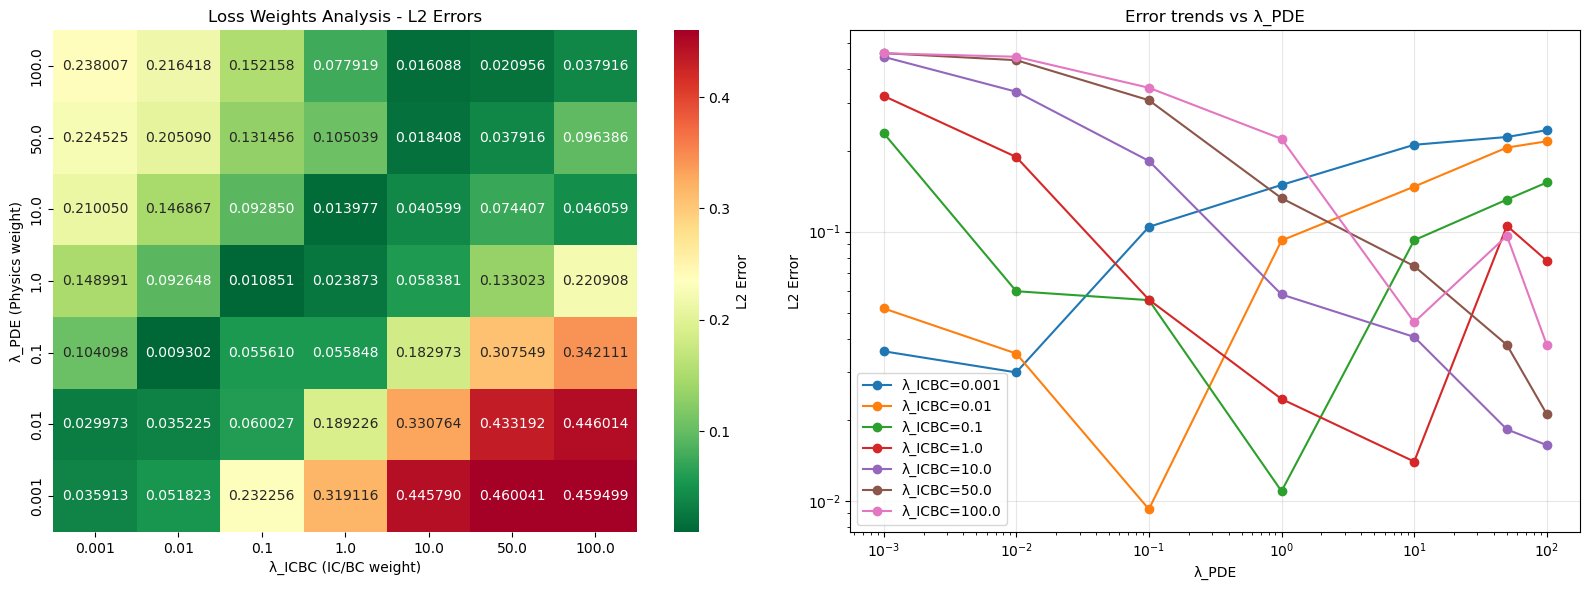

In [27]:
def plot_loss_analysis_enhanced(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap
    sns.heatmap(df, annot=True, fmt=".6f", cmap="RdYlGn_r", 
                ax=ax1, cbar_kws={'label': 'L2 Error'})
    ax1.set_title("Loss Weights Analysis - L2 Errors")
    ax1.set_xlabel("λ_ICBC (IC/BC weight)")
    ax1.set_ylabel("λ_PDE (Physics weight)")
    
    # Marquer le minimum
    min_val = df.min().min()
    print(f"Minimum L2 Error: {min_val:.6e} at position {df.stack().idxmin()}")
    min_pos = df.stack().idxmin()
    
    # Line plot des tendances
    for col in df.columns:
        ax2.plot(df.index, df[col], marker='o', label=f'λ_ICBC={col}')
    ax2.set_xlabel("λ_PDE")
    ax2.set_ylabel("L2 Error")
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title("Error trends vs λ_PDE")
    
    plt.tight_layout()
    plt.savefig('loss_analysis_complete.png', dpi=300)
    plt.show()

plot_loss_analysis_enhanced(df)

### The classic PINN limitation
A PINN model is trained to solve only one PDE problem (with specific parameters, IC/BC, domain).
This is a limitation compared to classical numerical methods (FDM, FEM, etc.) that can solve a wide range of problems with different parameters, IC/BC, domains, etc.
This is because the PINN is trained to minimize a loss function that is specific to the problem at hand.

## Data-Driven Solution of Inverse Problem of Burgers' Equation

Le problème inverse consiste à identifier les paramètres de l'équation de Burgers à partir de données observées:
- **λ₁**: coefficient du terme non-linéaire u·u_x (valeur attendue ≈ 1.0)
- **λ₂**: coefficient de viscosité ν (valeur attendue ≈ 0.00318 = 0.01/π)

L'équation de Burgers: `u_t + λ₁·u·u_x - λ₂·u_xx = 0`

In [7]:
# Import PINNinverse class
from src.networks import PINNinverse
import scipy.io

# Load exact solution data for training the inverse problem
data_mat = scipy.io.loadmat('./data/burgers_shock.mat')

t_exact = data_mat['t'].flatten()[:,None]
x_exact = data_mat['x'].flatten()[:,None]
Exact = np.real(data_mat['usol']).T

X_exact, T_exact = np.meshgrid(x_exact, t_exact)

X_star = np.hstack((X_exact.flatten()[:,None], T_exact.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Domain bounds for normalization
lb = X_star.min(0)  # Lower bounds [x_min, t_min]
ub = X_star.max(0)  # Upper bounds [x_max, t_max]

print(f"Domain bounds:")
print(f"  x ∈ [{lb[0]:.2f}, {ub[0]:.2f}]")
print(f"  t ∈ [{lb[1]:.2f}, {ub[1]:.2f}]")
print(f"Total data points: {X_star.shape[0]}")

Domain bounds:
  x ∈ [-1.00, 1.00]
  t ∈ [0.00, 0.99]
Total data points: 25600


In [8]:
# Sample training data from exact solution
# Following Raissi's approach: use N_u data points randomly sampled

N_u_inverse = 2000  # Number of data points for inverse problem
N_f_inverse = 10000 # Number of collocation points for PDE residual

# Randomly sample data points
np.random.seed(1234)
torch.manual_seed(1234)

idx_train = np.random.choice(X_star.shape[0], N_u_inverse, replace=False)
X_train = X_star[idx_train, :]
u_train = u_star[idx_train, :]

# Generate collocation points using Latin Hypercube Sampling
from pyDOE import lhs
X_f_train = lb + (ub - lb) * lhs(2, N_f_inverse)

# Convert to tensors on device
x_train = torch.tensor(X_train[:, 0:1], dtype=torch.float32, device=device, requires_grad=False)
t_train = torch.tensor(X_train[:, 1:2], dtype=torch.float32, device=device, requires_grad=False)
u_train_tensor = torch.tensor(u_train, dtype=torch.float32, device=device, requires_grad=False)

x_col_inverse = torch.tensor(X_f_train[:, 0:1], dtype=torch.float32, device=device, requires_grad=False)
t_col_inverse = torch.tensor(X_f_train[:, 1:2], dtype=torch.float32, device=device, requires_grad=False)

print(f"Training data: {N_u_inverse} points")
print(f"Collocation points: {N_f_inverse} points")
print(f"All tensors on device: {device}")

Training data: 2000 points
Collocation points: 10000 points
All tensors on device: cpu


In [11]:
# Initialize inverse PINN model
layers_inverse = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]  # Same architecture as Raissi

pinn_inverse = PINNinverse(
    layers=layers_inverse,
    activation=nn.Tanh(),
    lb=lb,
    ub=ub
).to(device)

# Initialize optimizer - start with Adam
# Raissi's approach: First train with Adam, then refine with L-BFGS
optimizer_inverse = optim.Adam(pinn_inverse.parameters(), lr=1e-3)

print("="*70)
print("Inverse Problem - Parameter Identification")
print("="*70)
print(f"Architecture: {layers_inverse}")
print(f"Data points: {N_u_inverse}")
print(f"Collocation points: {N_f_inverse}")
print(f"True parameters:")
print(f"  λ₁ = 1.0 (nonlinear term coefficient)")
print(f"  λ₂ (ν) = {nu:.7f} (viscosity)")
print(f"\nInitial parameter guess:")
print(f"  λ₁ = {pinn_inverse.lambda_1.item():.5f}")
print(f"  λ₂ (ν) = {torch.exp(pinn_inverse.lambda_2).item():.7f}")
print("="*70)

Inverse Problem - Parameter Identification
Architecture: [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
Data points: 2000
Collocation points: 10000
True parameters:
  λ₁ = 1.0 (nonlinear term coefficient)
  λ₂ (ν) = 0.0031831 (viscosity)

Initial parameter guess:
  λ₁ = 0.00000
  λ₂ (ν) = 0.0024788


In [ ]:
# Train with Adam first (warm-up phase)
print("\n Phase 1: Training with Adam optimizer...")
epochs_adam = 5000

loss_history_adam = pinn_inverse.train_inverse(
    optimizer_inverse,
    x_train, t_train, u_train_tensor,
    x_col_inverse, t_col_inverse,
    epochs=epochs_adam,
    log_interval=1000
)

# Get identified parameters after Adam
params_after_adam = pinn_inverse.get_parameters()
print("\n" + "="*70)
print("Parameters after Adam training:")
print(f"  λ₁ = {params_after_adam['lambda_1']:.5f} (true: 1.0)")
print(f"  λ₂ (ν) = {params_after_adam['lambda_2']:.7f} (true: {nu:.7f})")
error_lambda1_adam = np.abs(params_after_adam['lambda_1'] - 1.0) * 100
error_lambda2_adam = np.abs(params_after_adam['lambda_2'] - nu) / nu * 100
print(f"  Error λ₁: {error_lambda1_adam:.2f}%")
print(f"  Error λ₂: {error_lambda2_adam:.2f}%")
print("="*70)


 Phase 1: Training with Adam optimizer...


Training Inverse PINN:  20%|██        | 1003/5000 [00:50<03:18, 20.09it/s]

Epoch 1000/5000
  Total Loss: 9.675071e-03
  Data Loss: 7.204170e-03
  PDE Loss: 2.470900e-03
  λ₁: 0.55598
  λ₂ (ν): 0.0055344


Training Inverse PINN:  40%|████      | 2002/5000 [01:43<03:13, 15.52it/s]

Epoch 2000/5000
  Total Loss: 2.589861e-03
  Data Loss: 1.784851e-03
  PDE Loss: 8.050100e-04
  λ₁: 0.84912
  λ₂ (ν): 0.0074758


Training Inverse PINN:  60%|██████    | 3002/5000 [02:31<01:35, 20.89it/s]

Epoch 3000/5000
  Total Loss: 1.418384e-03
  Data Loss: 9.693777e-04
  PDE Loss: 4.490064e-04
  λ₁: 0.92378
  λ₂ (ν): 0.0072720


Training Inverse PINN:  66%|██████▋   | 3316/5000 [02:47<01:28, 19.02it/s]

In [ ]:
# Phase 2: Refine with L-BFGS optimizer
print("\nPhase 2: Refining with L-BFGS optimizer...")

optimizer_lbfgs = optim.LBFGS(
    pinn_inverse.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    tolerance_grad=1e-7,
    tolerance_change=1.0 * np.finfo(float).eps,
    history_size=50,
    line_search_fn='strong_wolfe'
)

loss_history_lbfgs = pinn_inverse.train_inverse(
    optimizer_lbfgs,
    x_train, t_train, u_train_tensor,
    x_col_inverse, t_col_inverse,
    epochs=1,  # L-BFGS will iterate internally
    log_interval=None
)

# Get final identified parameters
params_final = pinn_inverse.get_parameters()
print("\n" + "="*70)
print("FINAL IDENTIFIED PARAMETERS")
print("="*70)
print(f"λ₁ = {params_final['lambda_1']:.5f}")
print(f"  True value: 1.0")
print(f"  Error: {np.abs(params_final['lambda_1'] - 1.0) * 100:.3f}%")
print()
print(f"λ₂ (ν) = {params_final['lambda_2']:.7f}")
print(f"  True value: {nu:.7f}")
print(f"  Error: {np.abs(params_final['lambda_2'] - nu) / nu * 100:.3f}%")
print("="*70)

# Display the identified PDE
print(f"\nIdentified PDE:")
print(f"u_t + {params_final['lambda_1']:.5f}·u·u_x - {params_final['lambda_2']:.7f}·u_xx = 0")

In [ ]:
# Visualize parameter convergence
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Combine loss histories from both training phases
total_epochs_adam = len(loss_history_adam['total'])
epochs_combined = list(range(1, total_epochs_adam + 1)) + \
                  list(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['total']) + 1))

# Plot 1: Total Loss
ax = axes[0, 0]
ax.semilogy(range(1, total_epochs_adam + 1), loss_history_adam['total'], 'b-', label='Adam', linewidth=2)
if len(loss_history_lbfgs['total']) > 0:
    ax.semilogy(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['total']) + 1), 
                loss_history_lbfgs['total'], 'r-', label='L-BFGS', linewidth=2)
ax.axvline(total_epochs_adam, color='k', linestyle='--', alpha=0.5, label='Switch to L-BFGS')
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
ax.set_title('Total Loss History')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Data vs PDE Loss
ax = axes[0, 1]
ax.semilogy(range(1, total_epochs_adam + 1), loss_history_adam['data'], 'b-', label='Data Loss (Adam)', linewidth=2)
ax.semilogy(range(1, total_epochs_adam + 1), loss_history_adam['pde'], 'g-', label='PDE Loss (Adam)', linewidth=2)
if len(loss_history_lbfgs['data']) > 0:
    ax.semilogy(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['data']) + 1),
                loss_history_lbfgs['data'], 'b--', label='Data Loss (L-BFGS)', linewidth=2)
    ax.semilogy(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['pde']) + 1),
                loss_history_lbfgs['pde'], 'g--', label='PDE Loss (L-BFGS)', linewidth=2)
ax.axvline(total_epochs_adam, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Components')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Lambda_1 Convergence
ax = axes[1, 0]
ax.plot(range(1, total_epochs_adam + 1), loss_history_adam['lambda_1'], 'b-', linewidth=2, label='Identified λ₁')
if len(loss_history_lbfgs['lambda_1']) > 0:
    ax.plot(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['lambda_1']) + 1),
            loss_history_lbfgs['lambda_1'], 'b-', linewidth=2)
ax.axhline(1.0, color='r', linestyle='--', linewidth=2, label='True λ₁ = 1.0')
ax.axvline(total_epochs_adam, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('λ₁')
ax.set_title('Parameter λ₁ Convergence (nonlinear term coefficient)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Lambda_2 (nu) Convergence
ax = axes[1, 1]
ax.plot(range(1, total_epochs_adam + 1), loss_history_adam['lambda_2'], 'b-', linewidth=2, label='Identified λ₂ (ν)')
if len(loss_history_lbfgs['lambda_2']) > 0:
    ax.plot(range(total_epochs_adam + 1, total_epochs_adam + len(loss_history_lbfgs['lambda_2']) + 1),
            loss_history_lbfgs['lambda_2'], 'b-', linewidth=2)
ax.axhline(nu, color='r', linestyle='--', linewidth=2, label=f'True ν = {nu:.7f}')
ax.axvline(total_epochs_adam, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('ν (viscosity)')
ax.set_title('Parameter λ₂ (ν) Convergence (viscosity)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('inverse_problem_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate the inverse PINN solution and compare with exact solution
X_eval, T_eval, U_pred_inverse = evaluate_solution(pinn_inverse, n_x=200, n_t=200, device=device)

# Compute solution error
u_pred_all = pinn_inverse.forward(
    torch.tensor(X_star[:, 0:1], dtype=torch.float32, device=device),
    torch.tensor(X_star[:, 1:2], dtype=torch.float32, device=device)
)
if u_pred_all.device.type != 'cpu':
    u_pred_all = u_pred_all.cpu()
u_pred_all = u_pred_all.detach().numpy()

error_u = np.linalg.norm(u_star - u_pred_all, 2) / np.linalg.norm(u_star, 2)

print("\n" + "="*70)
print("SOLUTION ACCURACY")
print("="*70)
print(f"Relative L2 error on full solution: {error_u:.6e}")
print("="*70)

In [ ]:
# Visualize results - Comparison of Exact vs Predicted Solution
fig = plt.figure(figsize=(18, 10))

# Row 1: Exact Solution
ax1 = fig.add_subplot(2, 3, 1)
c1 = ax1.contourf(T_exact, X_exact, Exact, levels=50, cmap='RdBu_r')
ax1.scatter(t_train.cpu(), x_train.cpu(), c='k', s=2, label=f'Training data ({N_u_inverse} points)')
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Exact Solution u(x,t)')
plt.colorbar(c1, ax=ax1)
ax1.legend(loc='upper right')

# Row 1: Predicted Solution
ax2 = fig.add_subplot(2, 3, 2)
c2 = ax2.contourf(T_eval, X_eval, U_pred_inverse, levels=50, cmap='RdBu_r')
ax2.scatter(t_train.cpu(), x_train.cpu(), c='k', s=2, label='Training data')
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Predicted Solution (Inverse PINN)')
plt.colorbar(c2, ax=ax2)
ax2.legend(loc='upper right')

# Row 1: Absolute Error
ax3 = fig.add_subplot(2, 3, 3)
# Interpolate predicted solution to exact grid
from scipy.interpolate import griddata as gd
U_pred_interp = gd(np.c_[T_eval.flatten(), X_eval.flatten()], 
                   U_pred_inverse.flatten(),
                   (T_exact, X_exact), method='cubic')
error_field = np.abs(Exact - U_pred_interp)
c3 = ax3.contourf(T_exact, X_exact, error_field, levels=50, cmap='hot')
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title(f'Absolute Error (L2: {error_u:.3e})')
plt.colorbar(c3, ax=ax3)

# Row 2: Solution snapshots at different times
time_indices = [0, 25, 50, 75, 99]
time_labels = ['t=0.00', 't=0.25', 't=0.50', 't=0.75', 't=1.00']

for i, (idx, label) in enumerate(zip(time_indices, time_labels[:3])):
    ax = fig.add_subplot(2, 3, 4 + i)
    ax.plot(x_exact, Exact[idx, :], 'b-', linewidth=2, label='Exact')
    
    # Get predicted solution at this time
    t_snap = t_exact[idx, 0]
    U_snap_idx = int((t_snap / 1.0) * (U_pred_inverse.shape[0] - 1))
    ax.plot(X_eval[U_snap_idx, :], U_pred_inverse[U_snap_idx, :], 'r--', linewidth=2, label='Predicted')
    
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.savefig('inverse_problem_solution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Summary table comparing true and identified parameters
print("\n" + "="*70)
print("                    PARAMETER IDENTIFICATION SUMMARY")
print("="*70)
print(f"{'Parameter':<20} {'True Value':<20} {'Identified':<20} {'Error':<15}")
print("-"*70)

lambda1_true = 1.0
lambda1_identified = params_final['lambda_1']
lambda1_error = np.abs(lambda1_identified - lambda1_true) * 100

lambda2_true = nu
lambda2_identified = params_final['lambda_2']
lambda2_error = np.abs(lambda2_identified - lambda2_true) / lambda2_true * 100

print(f"{'λ₁ (nonlinear)':<20} {lambda1_true:<20.5f} {lambda1_identified:<20.5f} {lambda1_error:<15.3f}%")
print(f"{'λ₂ (viscosity ν)':<20} {lambda2_true:<20.7f} {lambda2_identified:<20.7f} {lambda2_error:<15.3f}%")
print("="*70)
print(f"\nIdentified Burgers Equation:")
print(f"u_t + {lambda1_identified:.5f}·u·u_x - {lambda2_identified:.7f}·u_xx = 0")
print(f"\nTrue Burgers Equation:")
print(f"u_t + {lambda1_true:.5f}·u·u_x - {lambda2_true:.7f}·u_xx = 0")
print("="*70)

In [ ]:
# Optional: Test with noisy data (as in Raissi's paper)
print("\n" + "="*70)
print("INVERSE PROBLEM WITH NOISY DATA (1% noise)")
print("="*70)

# Add 1% noise to training data
noise_level = 0.01
u_train_noisy = u_train + noise_level * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])
u_train_noisy_tensor = torch.tensor(u_train_noisy, dtype=torch.float32, device=device, requires_grad=False)

# Initialize new model for noisy case
pinn_inverse_noisy = PINNinverse(
    layers=layers_inverse,
    activation=nn.Tanh(),
    lb=lb,
    ub=ub
).to(device)

# Train with Adam
optimizer_noisy = optim.Adam(pinn_inverse_noisy.parameters(), lr=1e-3)
loss_history_noisy = pinn_inverse_noisy.train_inverse(
    optimizer_noisy,
    x_train, t_train, u_train_noisy_tensor,
    x_col_inverse, t_col_inverse,
    epochs=10000,
    log_interval=2000
)

params_noisy = pinn_inverse_noisy.get_parameters()

print("\n" + "="*70)
print("RESULTS WITH 1% NOISE")
print("="*70)
print(f"λ₁ = {params_noisy['lambda_1']:.5f} (error: {np.abs(params_noisy['lambda_1'] - 1.0) * 100:.3f}%)")
print(f"λ₂ (ν) = {params_noisy['lambda_2']:.7f} (error: {np.abs(params_noisy['lambda_2'] - nu) / nu * 100:.3f}%)")
print("="*70)
print("\nComparison:")
print(f"  Clean data error λ₁: {lambda1_error:.3f}%")
print(f"  Noisy data error λ₁: {np.abs(params_noisy['lambda_1'] - 1.0) * 100:.3f}%")
print(f"  Clean data error λ₂: {lambda2_error:.3f}%")
print(f"  Noisy data error λ₂: {np.abs(params_noisy['lambda_2'] - nu) / nu * 100:.3f}%")